## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [321]:
from types import SimpleNamespace
config = {
    'lower_yellow': np.uint8([ 10,   0, 100]), # lower threshold for yellow color in HSL
    'upper_yellow': np.uint8([ 40, 255, 255]), # upper threshold for yellow color in HSL
}
config = SimpleNamespace(**config)

## Compute the camera calibration using chessboard images

In [63]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
calibration_images = glob.glob('../camera_cal/calibration*.jpg')

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# Step through the list and search for chessboard corners
for fname in calibration_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        
        corners_sub = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners_sub)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners_sub, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
temp = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
mtx = temp[1] # camera matrix
dist = temp[2] # distortion coefficients
rvecs = temp[3] # rotation vector 
tvecs = temp[4] # translation vector

## Calculate Re-projection Error

Re-projection error gives a good estimation of just how exact is the found parameters. This should be as close to zero as possible. 

In [64]:
tot_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    tot_error += error

print("Total error: ", tot_error/len(objpoints))

Total error:  0.10841442348876729


## Image Undistortion

In [143]:
def undistort_image(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

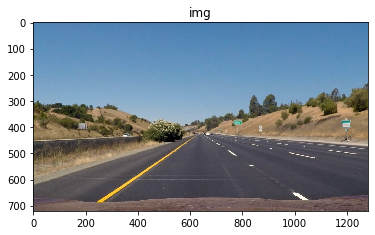

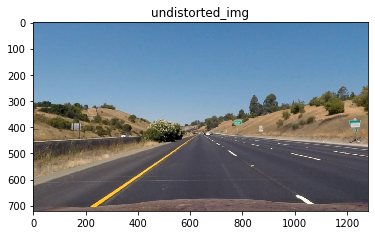

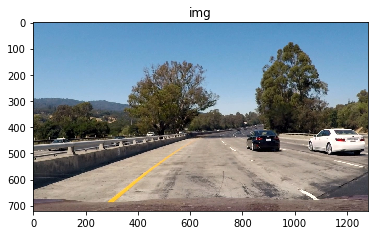

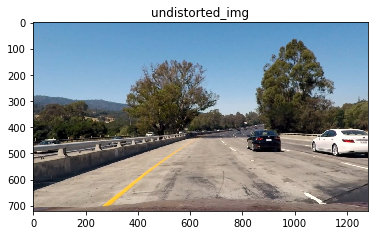

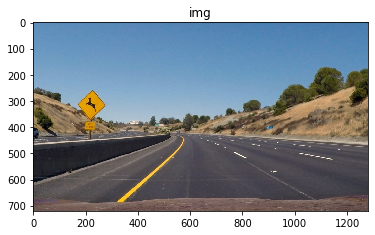

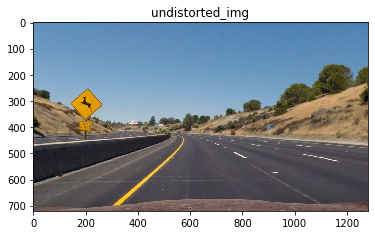

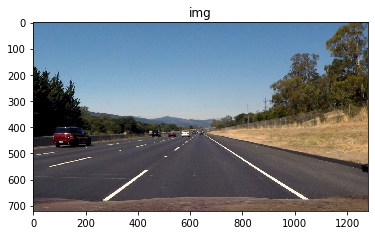

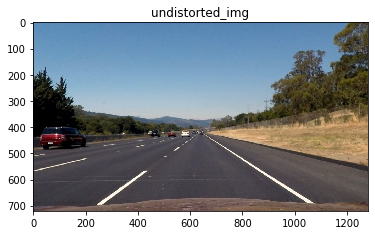

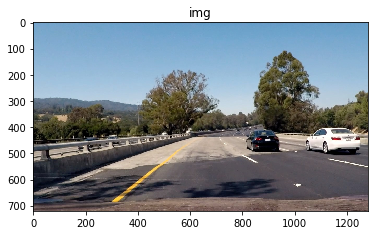

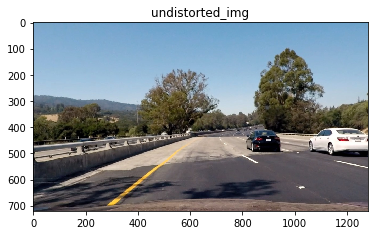

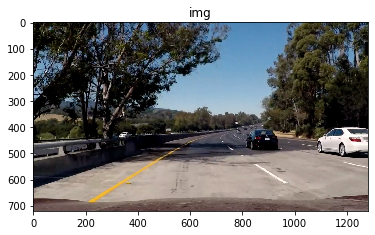

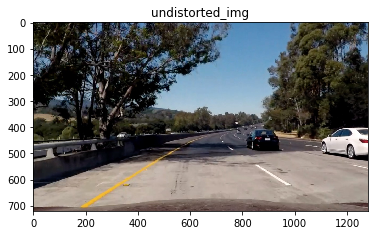

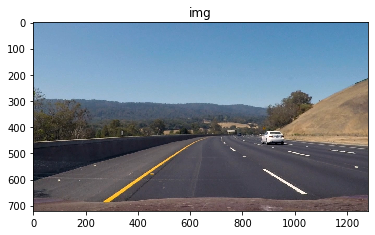

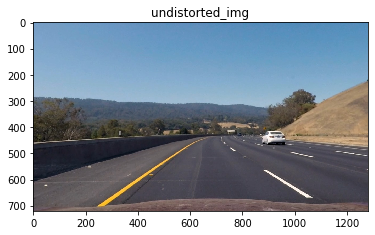

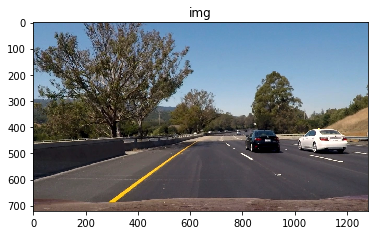

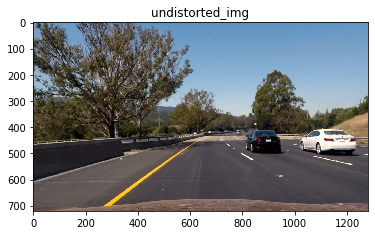

In [144]:
test_images = glob.glob('../test_images/*.jpg')
    
for fname in test_images:
    img = mpimg.imread(fname)
    undistorted_img = undistort_image(img, mtx, dist)
    plt.imshow(img)
    plt.title('img')
    plt.show()
    plt.title('undistorted_img')
    plt.imshow(undistorted_img)
    plt.show()


# Find lane points

## Helper functions

In [352]:
def convert_rgb_to_hsl(img):
    """Converts RGB iamge to HSL colorspace"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def extract_yellow_hls(img):
    """
    Extracts all white and yellow pixels in HSL colorspace
    
    This function expects an image in the HSL format. Make sure
    you have converted your image to this colorspace. Yellow and white pixels
    are extracted based on an upper and lower threshold. 
    """
    yellow_mask = cv2.inRange(img, config.lower_yellow, config.upper_yellow)
    return cv2.bitwise_and(img, img, mask = yellow_mask)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    rgb_image = cv2.cvtColor(img, cv2.COLOR_HLS2RGB)
    return cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient=='x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    elif orient=='y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

def region_of_interest_mask(img):
    """
    Constructs an image mask
    
    The region of interest has 4 vertices, which are 
    calculated based on the image dimension.
    """
    shape_img = img.shape
    vertices = np.array([[
        (0,shape_img[0]),
        ((9*shape_img[1])/20, (3*shape_img[0])/5),
        ((11*shape_img[1])/20, (3*shape_img[0])/5),
        (shape_img[1],shape_img[0])
    ]], dtype=np.int32)
    return vertices

def region_of_interest(img, vertices):
    """
    Applies an image mask
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def plt_images(img_1, title_1, img_2, title_2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap="gray")
    

In [390]:
def warp_image(img):
    src_coordinates = np.float32(
            [[280,  img.shape[0]-20],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, img.shape[0]-20]]) # Bottom right
        
    dst_coordinates = np.float32(
            [[250,  img.shape[0]],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, img.shape[0]]]) # Bottom right 
    
    # calculate the perspective transform matrix and warp
    # the perspective to grab the screen
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
    warp = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)
    return warp

def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

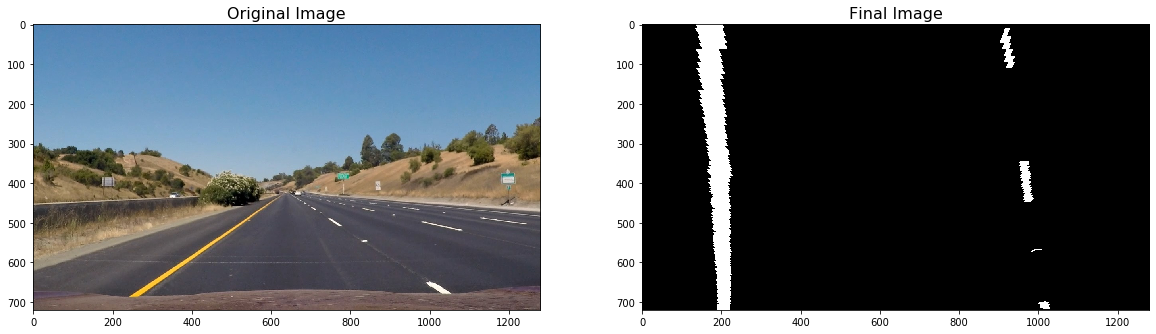

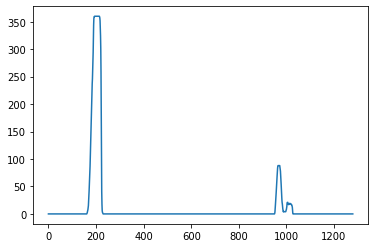

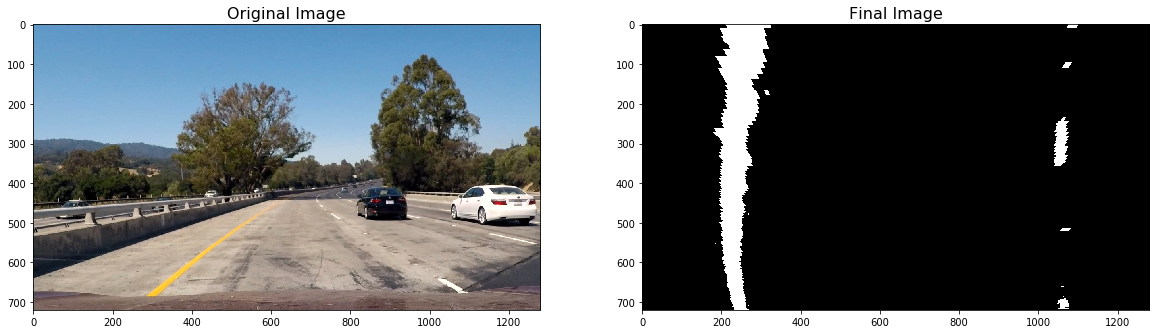

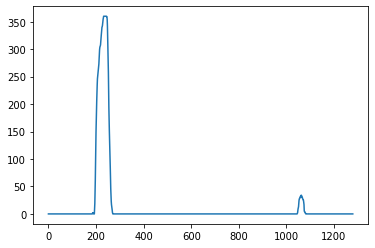

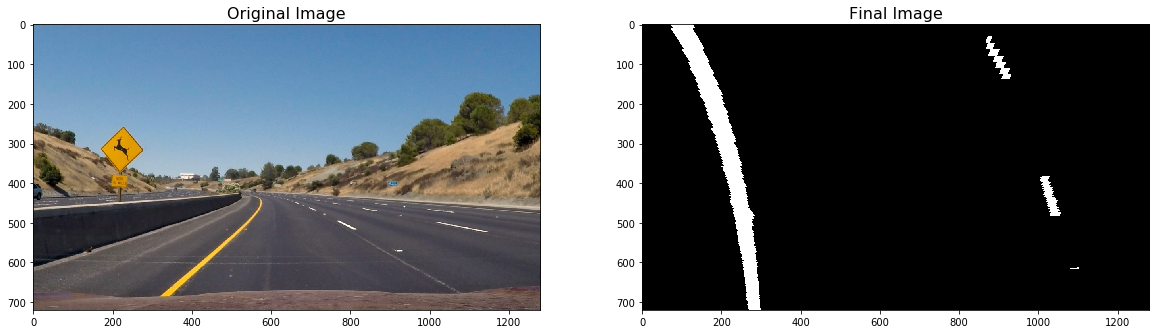

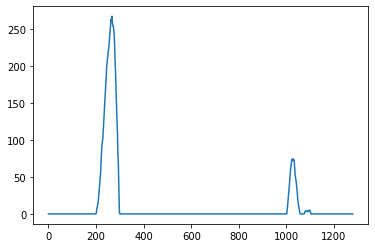

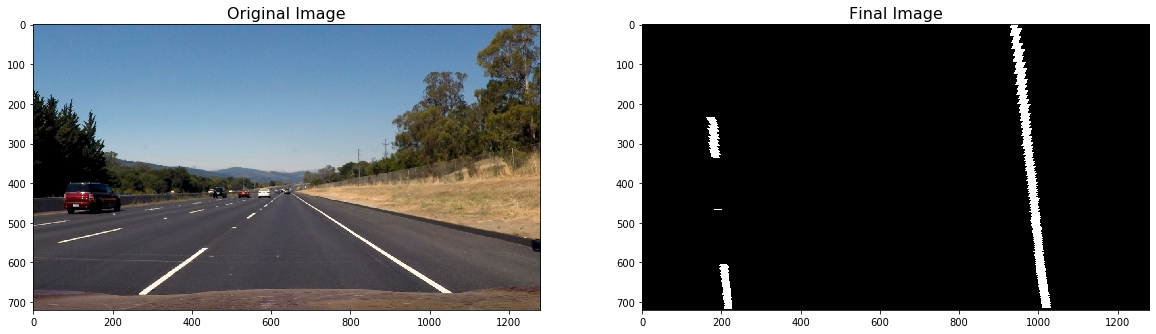

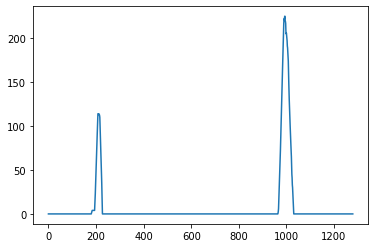

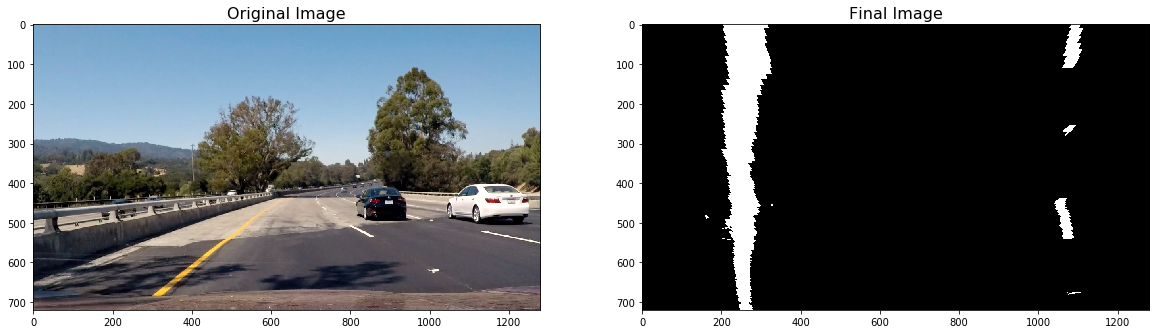

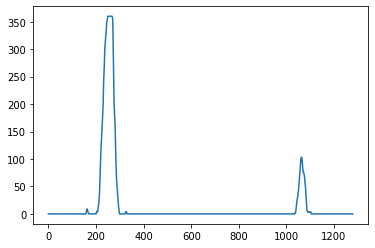

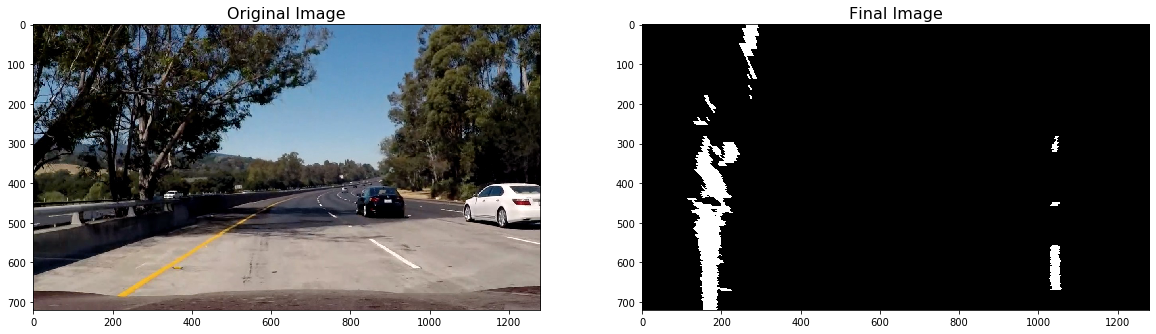

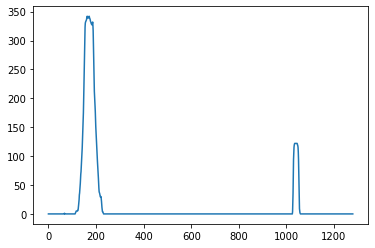

In [ ]:
for fname in test_images:
    img = mpimg.imread(fname)
    undistorted_img = undistort_image(img, mtx, dist)
    
    roi_mask = region_of_interest_mask(undistorted_img)
    roi_img = region_of_interest(undistorted_img, roi_mask)   
    
    yellow_img = extract_yellow_hls(cv2.cvtColor(roi_img, cv2.COLOR_RGB2HLS))
    temp = cv2.cvtColor(yellow_img, cv2.COLOR_HLS2RGB)
    gray_yellow=cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)
    
    gray = cv2.cvtColor(roi_img, cv2.COLOR_RGB2GRAY)

    yuv_img = cv2.cvtColor(roi_img, cv2.COLOR_RGB2YUV)
    yuv_planes = cv2.split(yuv_img)
    
    binary = np.zeros_like(yuv_planes[0])
    binary[(yuv_planes[1] < 110) | (gray > 210) | (gray_yellow > 0)] = 1

    warped_img = warp_image(binary)
    plt_images(img, 'Original Image', warped_img, 'Final Image')
    plt.show()
    
    hist_img = hist(warped_img)
    plt.plot(hist_img)
    plt.show()
    